# Movie Analysis Project
## By Clare Casey and Hannah Vollan Cole

# Dataset Description
Our dataset is actually two datasets. The IMDb movies, which is a dataset of 85855 movies with their title names, year of release, date of release, movie genres, duration (in minutes), movie country, movie language, and director name. There are more datasets within this dataset, which include total weighted average rating, total votes recieved, total mean vote, total median vote, and the number of votes of ratings equal to a certain number.

The second dataset has the names of the movies, years and whether or not the movie was a nominee or winner of the Oscar award for the best picture.

Our plan is to create a combined dataset with a new attribute, Oscar status, which will be able to be winner, nominee or not nominated. We will write a modified join fucntion that adds this new attribute to the IMDb movie dataset.

We will try to predict the Oscar status of each movie, and then create a test set with information about movies from this year to see if we can accurately predict whether a movie will be nominated or win the Best Picture Oscar.

https://www.kaggle.com/stefanoleone992/imdb-extensive-dataset?select=IMDb+movies.csv
https://www.kaggle.com/amandaiglesias/oscar-winners-and-nominees

In [340]:
# some useful mysklearn package import statements and reloads
import importlib
import random
import copy
import matplotlib.pyplot as plt

import mysklearn.myutils
importlib.reload(mysklearn.myutils)
import mysklearn.myutils as myutils

import mysklearn.mypytable
importlib.reload(mysklearn.mypytable)
from mysklearn.mypytable import MyPyTable 

import mysklearn.plot_utils
importlib.reload(mysklearn.plot_utils)
import mysklearn.plot_utils as plot_utils

import mysklearn.myclassifiers
importlib.reload(mysklearn.myclassifiers)
from mysklearn.myclassifiers import MyKNeighborsClassifier, MySimpleLinearRegressor, MyNaiveBayesClassifier

import mysklearn.myevaluation
importlib.reload(mysklearn.myevaluation)
import mysklearn.myevaluation as myevaluation
all_films_table = MyPyTable().load_from_file("input_data/all_films_cleaned.csv")
oscar_table = MyPyTable().load_from_file("input_data/oscars.csv")

## Data Preparation and Cleaning 

We first looked at the large dataset, which has approximately 85,000 instances, and looked for ways to trim the size. We trimmed a number of instances that included movies made before 1926. The data on Oscar wins and nominations only goes back to 1927, so earlier data would skew the tree, as they would be automatic snubbs. The colomuns we deleted are: "budget" "usa_gross_income", "worldwide_gross_income", "metascore", and "description". These columns contained too many missing values to be useful.

We created a MyPyTable for each of the two files, "all_films.csv" and "oscars.csv". We then retrieved the data from the MyPyTables, edited them, and joined them. This new data table that includes the data and class label of "winner", "nominee", or "snubbed", was written into a new file called "film_data.csv". 

(Look at films with high IMDB, group by genre, subsampling within genre, budget; check second dataset)

In [341]:
all_films = copy.deepcopy(all_films_table.data)
all_films_id = all_films_table.get_column("imdb_title_id")
oscar_noms = copy.deepcopy(oscar_table.data)
oscar_status = oscar_table.get_column("Position")
id_num = oscar_table.get_column("id_imdb")

all_films_table.column_names.append("oscar_status")
header = copy.deepcopy(all_films_table.column_names)

for film in all_films:
    # get rid of leading 't's from the id index in all_films
    film[0] = int(film[0].replace('t', ''))

# find if the film was a winner, nominated, or snubbed
# append a new column to each row with class label
for film in all_films:
    if film[0] in id_num:
        id_index = id_num.index(film[0])
        film.append(oscar_status[id_index])
    else:
        film.append("Snubbed")

# drop rows with low reviews
all_films_edit = []
for film in all_films:
    if film[13] > 6:
        all_films_edit.append(film)
    elif film[17] == "Winner" or film[17] == "Nominee":
        all_films_edit.append(film)


In [342]:
# drop rows not made in the USA
all_films_edit2 = []
for film in all_films_edit:
    if type(film[3]) == str:
        pass
    elif "USA" in film[7]:
        all_films_edit2.append(film)
    # keeps the few foreign movies that were nominated for the oscar before 2000
    elif film[17] == "Winner" or film[17] == "Nominee":
        all_films_edit2.append(film)

# drop rows with fewer than 800 reviews
all_films_edit3 = []
print("film14 type", type(all_films_edit2[4][14]))
for film in all_films_edit2:
    if type(film[14]) == str or film[14] == '':
        pass
    elif int(film[14]) > 800:
        all_films_edit3.append(film)    
    # keeps the movies nominated for an oscar
    elif film[17] == "Winner" or film[17] == "Nominee":
        all_films_edit3.append(film)

# drops movies that are less than 90 minutes long
all_films_edit4 = []
for film in all_films_edit3:
    if int(film[6]) > 90:
        all_films_edit4.append(film)
    elif film[17] == "Winner" or film[17] == "Nominee":
        all_films_edit4.append(film)

# drops films that have fewer than 50 reviews by critics and users
all_films_edit5 = []
for film in all_films_edit4:
    if type(film[15]) == str or film[15] == '':
        pass
    elif type(film[16]) == str or film[16] == '':
        pass
    elif film[15] > 50 and film[16] > 50:
        all_films_edit5.append(film)
    elif film[17] == "Winner" or film[17] == "Nominee":
        all_films_edit5.append(film)

# drop rows where English is not one of the languages
all_films_edit6 = []
for film in all_films_edit5:
    if "English" in film[8]:
        all_films_edit6.append(film)
    elif film[17] == "Winner" or film[17] == "Nominee":
        all_films_edit6.append(film)

film_data = MyPyTable(header, all_films_edit6)
film_data.save_to_file("film_data.csv")

film14 type <class 'float'>


{'Snubbed': 3321, 'Nominee': 463, 'Winner': 91}


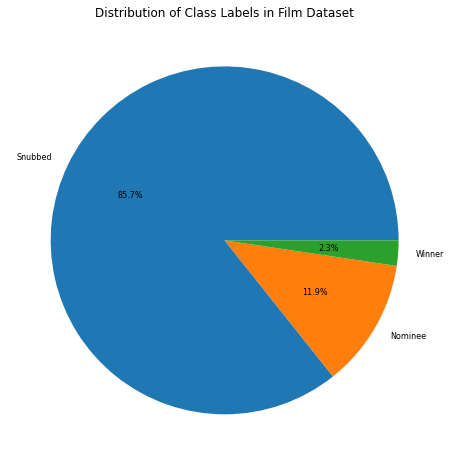

In [343]:
class_labels = copy.deepcopy(film_data.get_column("oscar_status"))
freq_dict = myutils.create_dictionary(class_labels)
names = list(freq_dict.keys())
freqs = list(freq_dict.values())

print(freq_dict)
plot_utils.make_pie_chart_with_comp(names, freqs, "Distribution of Class Labels in Film Dataset")

## Initial EDA on "film_data.csv"

### Pi Chart of Class Labels

### Histogram of Film Genres

The "genre" column of data is a string that contains one or more genre names. This would not be handled well by our plot utils. Therefore, we searched the string for a substring, genre name in genre_lst, and if the substring was found, we appended it to a list. 

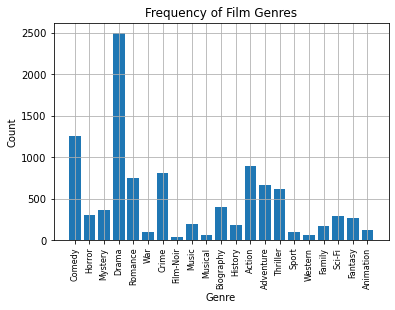

In [344]:
# list of possible genres
genre_lst = ["Action", "Adventure", "Animation", "Biography", "Comedy", "Crime","Documentary", "Drama", "Family", "Fantasy", "Film-Noir", "History", "Horror", "Music", "Musical", "Mystery", "News", "Romance", "Sci-Fi", "Sport", "Thriller", "Western", "War"]
genre_col = copy.deepcopy(film_data.get_column("genre"))
genres = []
for row in genre_col:
    for item in genre_lst:
        if row.find(item) != -1:
            genres.append(item)


plot_utils.make_bar_graph_with_column(genres, "Frequency of Film Genres", "Genre", "Count", 8)

## Scatter Plot that shows the Average Rating Compared to the Number of Ratings

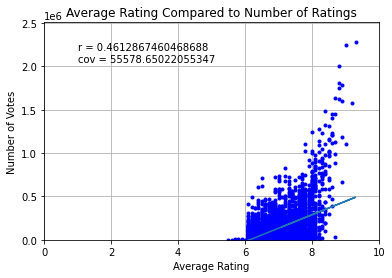

In [345]:
plot_utils.make_scatter_plot(film_data, "avg_vote", "votes", "Average Rating Compared to Number of Ratings", "Average Rating", "Number of Votes")

# Naive Bayes Classifier 

In [346]:
NaiveBayes = MyNaiveBayesClassifier()
X = []
y = []
data_table = copy.deepcopy(film_data)
data_table.remove_rows_with_missing_values()
data = copy.deepcopy(data_table.data)
for row in data:
    new_row = []
    y.append(row[-1])
    for item in row[:17]:
        new_row.append(item)
    X.append(new_row)
X_half = []
y_half = []
for i in range(int((len(X)/2)), (len(X))):
    X_half.append(X[i])
    y_half.append(y[i])
X_half_edit = []
for i in range(len(X_half)):
    for j in range(len(X_half[0])):
        new_row = []
        if j != 5:
            if j!= 10:
                if j!= 12:
                    new_row.append(X_half[i][j])
    X_half_edit.append(new_row)
X_train, X_test, y_train, y_test = myevaluation.train_test_split(X_half_edit, y_half)
NaiveBayes.fit(X_train, y_train)
predicted = NaiveBayes.predict(X_test)
print("y_test", y_test[0:500])
print()
print("y_pred", predicted[0:500])
myevaluation.confusion_matrix(y_test, predicted, ["Winner", "Nominee", "Snubbed"])

y_test ['Snubbed', 'Snubbed', 'Snubbed', 'Snubbed', 'Snubbed', 'Snubbed', 'Snubbed', 'Nominee', 'Snubbed', 'Nominee', 'Nominee', 'Snubbed', 'Snubbed', 'Snubbed', 'Snubbed', 'Snubbed', 'Snubbed', 'Snubbed', 'Snubbed', 'Snubbed', 'Snubbed', 'Snubbed', 'Snubbed', 'Snubbed', 'Snubbed', 'Snubbed', 'Snubbed', 'Snubbed', 'Snubbed', 'Snubbed', 'Snubbed', 'Snubbed', 'Snubbed', 'Snubbed', 'Snubbed', 'Snubbed', 'Snubbed', 'Snubbed', 'Snubbed', 'Snubbed', 'Snubbed', 'Snubbed', 'Snubbed', 'Snubbed', 'Snubbed', 'Snubbed', 'Snubbed', 'Snubbed', 'Snubbed', 'Snubbed', 'Snubbed', 'Snubbed', 'Snubbed', 'Snubbed', 'Snubbed', 'Snubbed', 'Snubbed', 'Snubbed', 'Snubbed', 'Snubbed', 'Snubbed', 'Snubbed', 'Snubbed', 'Snubbed', 'Snubbed', 'Snubbed', 'Snubbed', 'Snubbed', 'Snubbed', 'Snubbed', 'Snubbed', 'Snubbed', 'Snubbed', 'Snubbed', 'Snubbed', 'Snubbed', 'Snubbed', 'Snubbed', 'Snubbed', 'Snubbed', 'Snubbed', 'Snubbed', 'Snubbed', 'Nominee', 'Snubbed', 'Snubbed', 'Snubbed', 'Snubbed', 'Snubbed', 'Snubbed', 'S

[[0, 0, 6], [0, 1, 34], [1, 11, 587]]

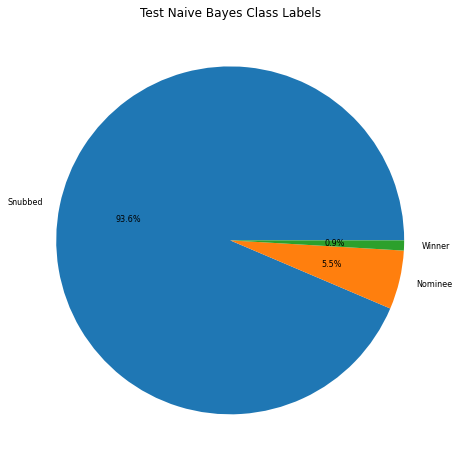

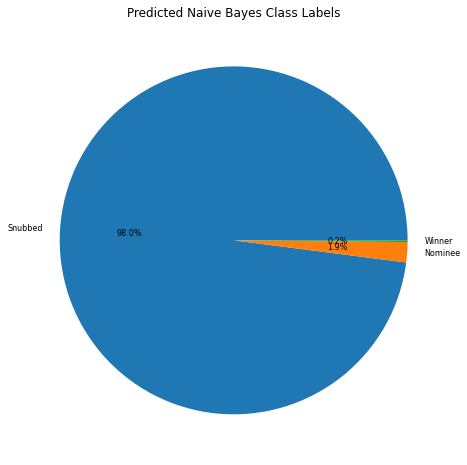

In [347]:
naive_bayes_test_labels = copy.deepcopy(y_test[0:2000])
naive_bayes_predicted_labels = copy.deepcopy(predicted[0:2000])
naive_bayes_test_freq_dict = myutils.create_dictionary(naive_bayes_test_labels)
naive_bayes_predicted_freq_dict = myutils.create_dictionary(naive_bayes_predicted_labels)
nb_test_names = list(naive_bayes_test_freq_dict.keys())
nb_test_freqs = list(naive_bayes_test_freq_dict.values())
nb_predicted_names = list(naive_bayes_predicted_freq_dict.keys())
nb_predicted_freqs = list(naive_bayes_predicted_freq_dict.values())

plot_utils.make_pie_chart_with_comp(nb_test_names, nb_test_freqs, "Test Naive Bayes Class Labels")
plot_utils.make_pie_chart_with_comp(nb_predicted_names, nb_predicted_freqs, "Predicted Naive Bayes Class Labels")

# Next Steps:
1. Replace critical missing values with averages (of whole column or a tailored subset)
2. Remove significant amount of "snubbed" instances
3. Make sure all oscar winners and nominees are in the dataset, even if we have to find data for them ourselves. 
4. Deal with racism issue??? Anything not in English will be looked over by the trees. 